In [14]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------------
# Parameters
# -------------------------------
img_height, img_width = 224, 224
batch_size = 32
max_epochs = 300  # Maximum epochs to train

# Adam optimizer parameters
learning_rate = 1e-4
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-7

# Early stopping: monitor validation loss with a patience of 15 epochs,
# and restore the best model weights
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# -------------------------------
# Paths & Filter Selection
# -------------------------------
# Preprocessed dataset path (images are already resized and augmented)
preprocessed_dataset_path = "/content/drive/MyDrive/Balanced_dataset_split"

# Use only the K720_balance filter
filter_name = "hotmirror_balance"

# Define class names (must match the folder names inside K590_balance)
classes = [
    "Papaya_healthy", "Papaya_diseased",
    "Potato_healthy", "Potato_diseased",
    "Tomato_healthy", "Tomato_diseased"
]

# Construct paths for train, validation, and test directories
filter_path = os.path.join(preprocessed_dataset_path, filter_name)
train_dir = os.path.join(filter_path, 'train')
validation_dir = os.path.join(filter_path, 'validation')
test_dir = os.path.join(filter_path, 'test')

# -------------------------------
# Data Generators
# -------------------------------
# Since images are preprocessed, we only need to rescale them.
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2121 images belonging to 6 classes.
Found 264 images belonging to 6 classes.
Found 267 images belonging to 6 classes.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Build the Xception Model
# -------------------------------
# Load the pre-trained Xception model without its top layers.
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers to retain the ImageNet features.
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for classification.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(len(classes), activation='softmax')(x)

In [16]:
# Create the full model.
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with the Adam optimizer configured as specified.
optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Optional: Display model architecture.
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,873,774 (79.63 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [17]:
# Train the Model with Early Stopping
# -------------------------------
history = model.fit(
    train_generator,
    epochs=max_epochs,
    validation_data=validation_generator,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 900s 13s/step - accuracy: 0.1585 - loss: 1.8941 - val_accuracy: 0.3371 - val_loss: 1.6024
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.3133 - loss: 1.6315 - val_accuracy: 0.4735 - val_loss: 1.4453
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.4036 - loss: 1.4590 - val_accuracy: 0.5379 - val_loss: 1.3304
Epoch 4/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.4459 - loss: 1.3700 - val_accuracy: 0.5720 - val_loss: 1.2417
Epoch 5/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.5330 - loss: 1.2564 - val_accuracy: 0.5720 - val_loss: 1.1707
Epoch 6/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 0.5643 - loss: 1.1830 - val_accuracy: 0.6061 - val_loss: 1.1150
Epoch 7/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.5944 - loss: 1.1083 - val_accuracy: 0.6515 - val_loss: 1.0668
Epoch 8/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.5956 - loss: 1.0806 - v

In [18]:
# -------------------------------
# Evaluate the Model on Test Set
# -------------------------------
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))


9/9 ━━━━━━━━━━━━━━━━━━━━ 90s 11s/step - accuracy: 0.8274 - loss: 0.4206
Test Accuracy: 84.64%


In [20]:
# -------------------------------
# Compute Detailed Metrics on Test Set
# -------------------------------
# Get predictions on the test set.
test_preds = model.predict(test_generator)
y_pred = np.argmax(test_preds, axis=1)
y_true = test_generator.classes

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step


In [21]:
# Generate classification report (includes precision, recall, f1-score)
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


Classification Report:
                 precision    recall  f1-score   support

Papaya_diseased       0.88      0.73      0.80        30
 Papaya_healthy       0.82      0.86      0.84        36
Potato_diseased       0.83      0.87      0.85        63
 Potato_healthy       0.83      0.81      0.82        48
Tomato_diseased       0.87      0.87      0.87        45
 Tomato_healthy       0.87      0.89      0.88        45

       accuracy                           0.85       267
      macro avg       0.85      0.84      0.84       267
   weighted avg       0.85      0.85      0.85       267



In [23]:
# Compute confusion matrix.
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[22  7  1  0  0  0]
 [ 2 31  0  0  1  2]
 [ 0  0 55  8  0  0]
 [ 1  0  8 39  0  0]
 [ 0  0  2  0 39  4]
 [ 0  0  0  0  5 40]]


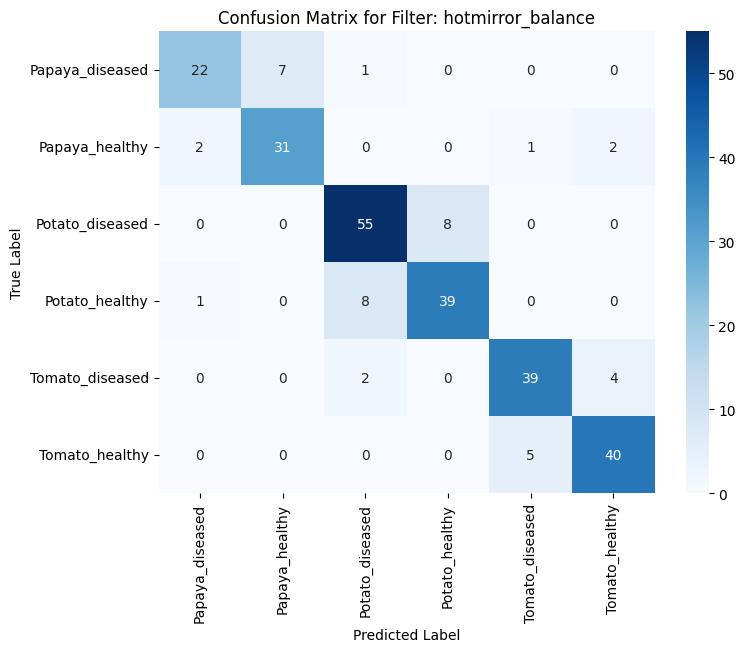

In [24]:
# -------------------------------
# Visualize the Confusion Matrix
# -------------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Filter: " + filter_name)
plt.show()

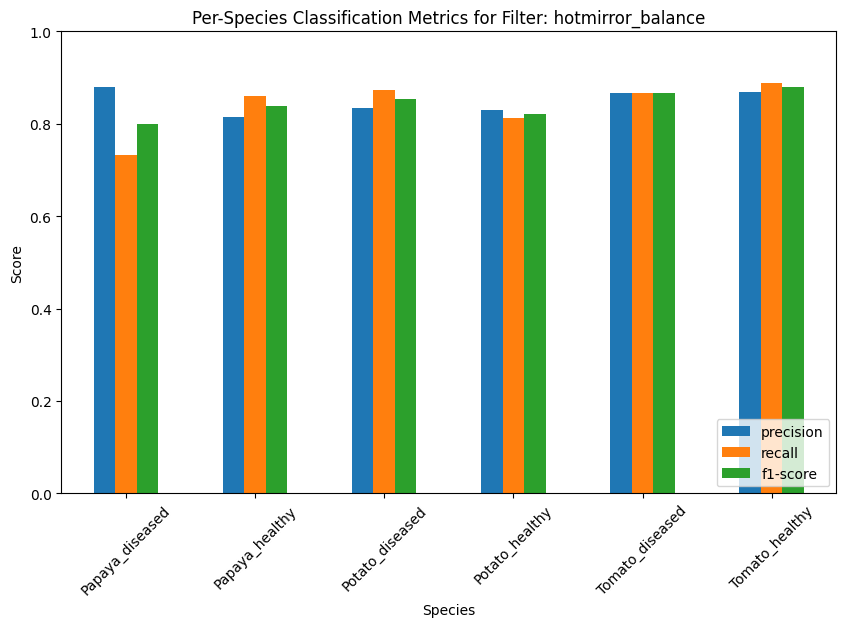

In [25]:
import pandas as pd
# -------------------------------
# Visualize Per-Species Metrics (Precision, Recall, F1-Score)
# -------------------------------
# Convert the classification report to a DataFrame for selected metrics.
report_df = pd.DataFrame(report).transpose()
metrics_df = report_df.loc[target_names, ['precision', 'recall', 'f1-score']]

metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Per-Species Classification Metrics for Filter: " + filter_name)
plt.xlabel("Species")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


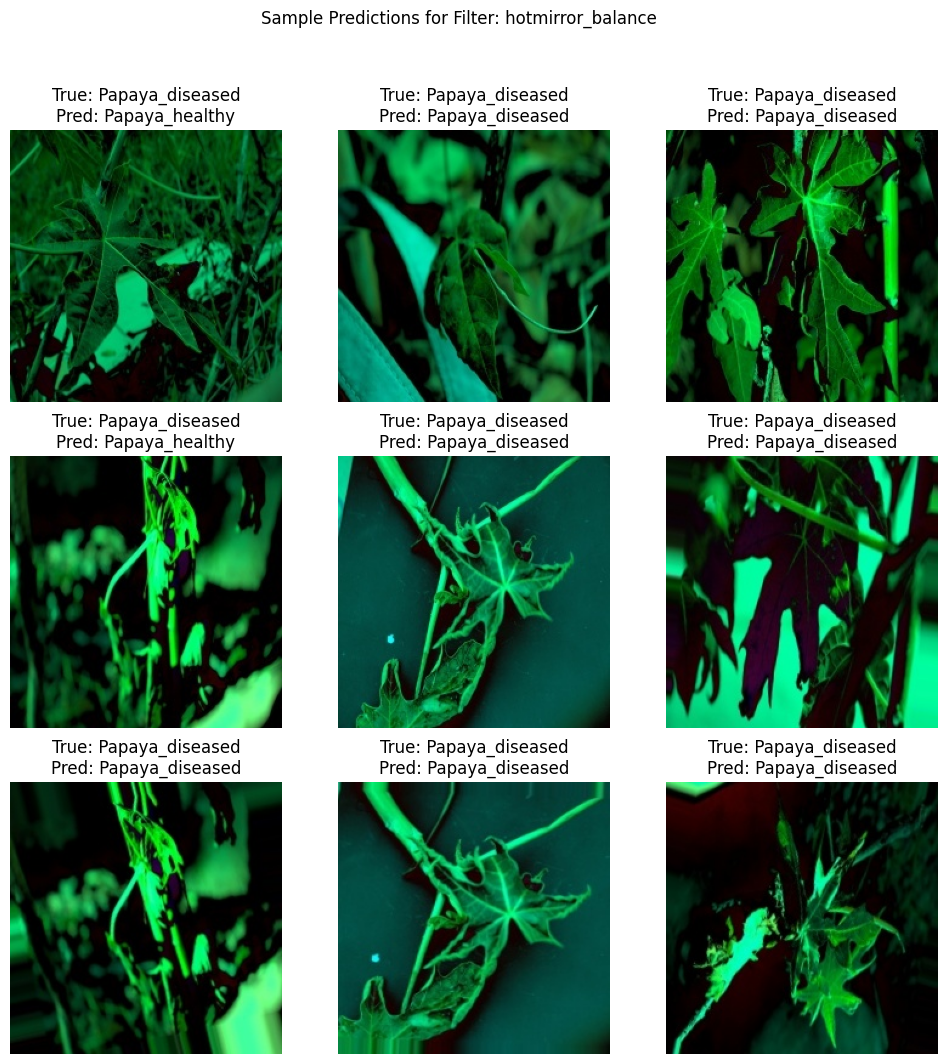

In [26]:
# -------------------------------
# Visualize Sample Test Images with Predictions
# -------------------------------
# Get a batch of test images.
test_images, test_labels = next(test_generator)
preds = model.predict(test_images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(test_labels, axis=1)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[i])
    plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}")
    plt.axis('off')
plt.suptitle("Sample Predictions for Filter: " + filter_name)
plt.show()

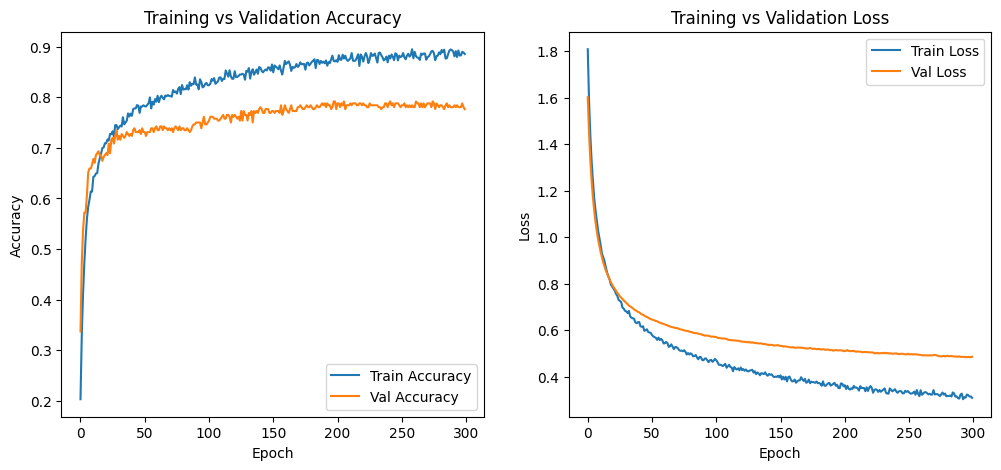

In [27]:
# -------------------------------
# Visualize Training History (Accuracy and Loss)
# -------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()